In [236]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

In [237]:
#Checking wich GPU is beeing used

!nvidia-smi

Mon Nov 22 11:29:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   27C    P8    18W / 250W |  10073MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [238]:
#Load data
data_file = 'dialogue/Dataset/VoiceDetection/Output.npy'
labels = pd.read_csv("dialogue/Dataset/VoiceDetection/boolean_labels.csv")#path to csv
labels.drop(labels.columns[[0]], axis=1, inplace=True)
data = np.load(data_file, allow_pickle= True)
df_temp = pd.DataFrame()
df_data = pd.DataFrame()
#print(data)
df_data = pd.DataFrame(data)
#df_data['data'] = df_temp.values.tolist()
df_data = pd.concat([df_data, labels], axis = 1)
print(df_data.head())
np_labels = df_data['isSpeaking'].to_numpy()
np_data = data #df_data['data'].to_numpy()
#print(df_data)

             0            1            2            3             4  \
0   642.748596   599.666016   457.385864  2329.083496    544.685669   
1  2483.761719  1879.810913  1751.349365  1365.619141  11521.102539   
2  2974.510254  2417.348389  3596.662598  8164.546387  10680.574219   
3  2299.291992  2659.267090  6782.927246  4986.243652   4692.127930   
4  7250.499023  5618.221191  2935.614746  2010.994629   2364.952881   

              5             6             7             8             9  ...  \
0  10115.502930   3740.024658   5950.273926   8270.299805   7102.328613  ...   
1  35269.847656  22174.640625  10486.954102  10991.354492  29539.894531  ...   
2  18837.330078  12147.911133  12596.525391  14583.992188  15486.234375  ...   
3   6167.210449   7342.863770  20316.238281  20269.578125  17777.810547  ...   
4  32199.175781  19769.033203   4626.022949   2546.629883   2868.554443  ...   

       2391      2392      2393      2394      2395      2396      2397  \
0  1.125655  4.33

In [239]:
#df_data.drop(['isSpeaking'],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(np_data, np_labels, test_size = 0.2, random_state = 23)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 23)
print(type(X_train))
#print(X_train)

<class 'numpy.ndarray'>


In [240]:
#print(pd.DataFrame(X_train))
X_train = torch.from_numpy(X_train).float()
X_train = X_train.unsqueeze_(-1)
X_train = X_train.transpose(2, 0)
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
X_test = X_test.unsqueeze_(-1)
X_test = X_test.transpose(2, 0)        #torch.tensor(X_test.values)
y_test = torch.from_numpy(y_test).float()
X_val = torch.from_numpy(X_val).float()
X_val = X_val.unsqueeze_(-1)
X_val = X_val.transpose(2, 0)
y_val = torch.from_numpy(y_val).float()
#print(X_val.shape, X_val)
print(X_train.shape, y_train.shape)
#print(test_X.shape)
#print(X_train)


torch.Size([1, 2400, 1472]) torch.Size([1472])


In [241]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 1280, kernel_size=1, stride = 1) #1 input channels, 100 output channels
        self.conv2 = nn.Conv1d(1280, 320, kernel_size=1, stride = 1) #100 input channels from previous Conv. layer, 75 out
        self.conv3 = nn.Conv1d(320, 160, kernel_size=1, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv4 = nn.Conv1d(160, 80, kernel_size=1, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv5 = nn.Conv1d(80, 60, kernel_size=1, stride = 1) #75 input channels from previous Conv. layer, 50 out
        self.conv5_drop = nn.Dropout2d() #dropout
        
        self.fc1 = nn.Linear(60, 50) #Fully-connected classifier layer
        self.fc2 = nn.Linear(50, 40) #Fully-connected classifier layer
        self.fc3 = nn.Linear(40, 30) #Fully-connected classifier layer
        self.fc4 = nn.Linear(30, 20) #Fully-connected classifier layer
        self.fc5 = nn.Linear(20,1) #Fully-connected classifier layer
    
    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 1))
        x = F.relu(F.max_pool1d(self.conv2(x), 1))
        x = F.relu(F.max_pool1d(self.conv3(x), 1))
        x = F.relu(F.max_pool1d(self.conv4(x), 1))
        x = F.relu(F.max_pool1d(self.conv5_drop(self.conv5(x)), 1))
        
        #point A
        x = x.transpose(1, 2)
        
        #point B
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc4(x)
        return torch.sigmoid(self.fc5(x))
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X_train.shape[1],kernel_size = 1)

In [242]:
weight = torch.FloatTensor([1])
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.001)

In [243]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
CNN = CNN.to(device)
criterion = criterion.to(device)

In [244]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [245]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_test', 'test_loss', 'train_loss'])
    
for epoch in range(1000):
        y_pred = CNN(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)
        if epoch % 10 == 0:
        
            train_acc = calculate_accuracy(y_train, CNN.post_forward(y_pred))
        
            y_test_pred = CNN(X_test)

            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred, y_test)
        
            test_acc = calculate_accuracy(y_test, CNN.post_forward(y_test_pred))
        
            result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_test': round_tensor(test_acc), 'test_loss': round_tensor(test_loss), 'train_loss': round_tensor(train_loss)}

            Results = Results.append(result, ignore_index=True)

            print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
        optimizer.zero_grad()
    
        train_loss.backward()
    
        optimizer.step()


epoch 0
Train set - loss: 0.73, accuracy: 0.467
Test  set - loss: 0.718, accuracy: 0.472

epoch 10
Train set - loss: 0.487, accuracy: 0.758
Test  set - loss: 0.479, accuracy: 0.787

epoch 20
Train set - loss: 0.365, accuracy: 0.779
Test  set - loss: 0.554, accuracy: 0.676

epoch 30
Train set - loss: 0.256, accuracy: 0.923
Test  set - loss: 0.529, accuracy: 0.883

epoch 40
Train set - loss: 0.187, accuracy: 0.941
Test  set - loss: 0.408, accuracy: 0.904

epoch 50
Train set - loss: 0.15, accuracy: 0.946
Test  set - loss: 0.744, accuracy: 0.891

epoch 60
Train set - loss: 0.146, accuracy: 0.948
Test  set - loss: 0.374, accuracy: 0.928

epoch 70
Train set - loss: 0.158, accuracy: 0.944
Test  set - loss: 0.55, accuracy: 0.926

epoch 80
Train set - loss: 0.114, accuracy: 0.956
Test  set - loss: 0.233, accuracy: 0.93

epoch 90
Train set - loss: 0.11, accuracy: 0.954
Test  set - loss: 0.891, accuracy: 0.935

epoch 100
Train set - loss: 0.123, accuracy: 0.965
Test  set - loss: 1.099, accuracy: 

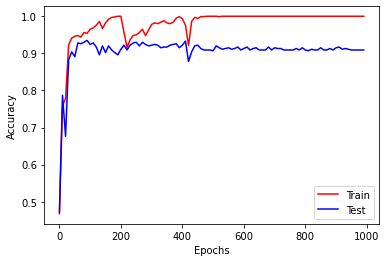

    Epoch  Acc_train  Acc_test  test_loss  train_loss
0     0.0      0.467     0.472      0.718       0.730
1    10.0      0.758     0.787      0.479       0.487
2    20.0      0.779     0.676      0.554       0.365
3    30.0      0.923     0.883      0.529       0.256
4    40.0      0.941     0.904      0.408       0.187
..    ...        ...       ...        ...         ...
95  950.0      1.000     0.909      6.897       0.000
96  960.0      1.000     0.909      5.720       0.000
97  970.0      1.000     0.909      6.827       0.000
98  980.0      1.000     0.909      6.046       0.000
99  990.0      1.000     0.909      6.207       0.000

[100 rows x 5 columns]


In [246]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_test,'b')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(Results)

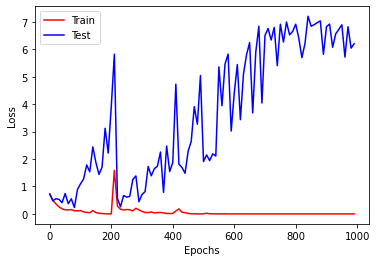

In [247]:
plt.plot(Results.Epoch,Results.train_loss,'r',Results.Epoch,Results.test_loss,'b')
plt.legend(['Train','Test'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [248]:
classes = ['No Voice', 'Voice']
y_pred = CNN(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       0.94      0.88      0.91       241
       Voice       0.88      0.94      0.91       219

    accuracy                           0.91       460
   macro avg       0.91      0.91      0.91       460
weighted avg       0.91      0.91      0.91       460



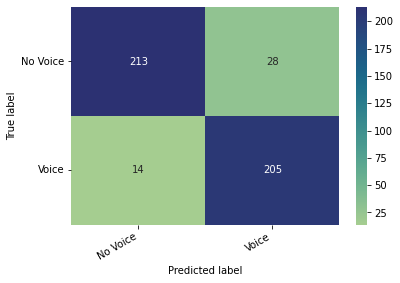

In [249]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
#hmap.color_palette("viridis", as_cmap=True)
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [250]:
y_pred = CNN(X_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

              precision    recall  f1-score   support

    No Voice       0.89      0.93      0.91       211
       Voice       0.90      0.85      0.88       157

    accuracy                           0.90       368
   macro avg       0.90      0.89      0.89       368
weighted avg       0.90      0.90      0.90       368



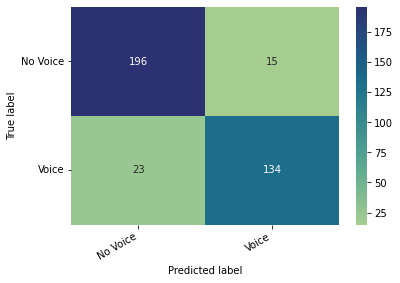

In [251]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [252]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
